In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init

import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

from pyqtorch.core.circuit import QuantumCircuit
from pyqtorch.ansatz import AlternateLayerAnsatz
from pyqtorch.embedding import SingleLayerEncoding
from pyqtorch.core.operation import Z, RX

# Generate a Hamiltonian from a graph

In [2]:
n_qubits = 3
n_nodes = n_qubits

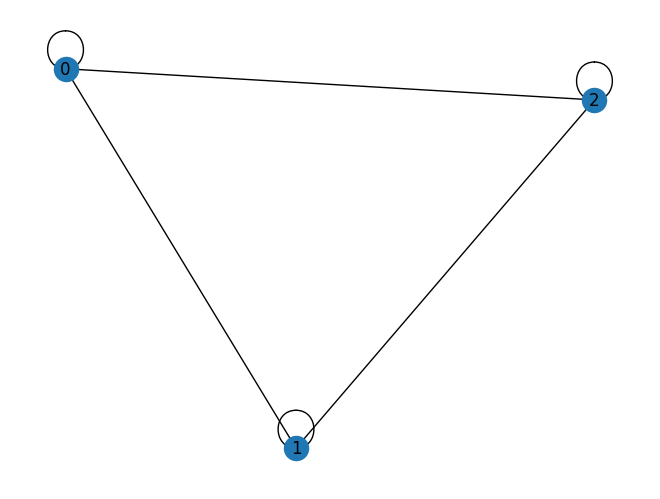

In [3]:
# random

# graph = nx.gnp_random_graph(n_nodes, 1., seed=42)

# or custom one

# graph = nx.Graph()
# graph.add_edge(0, 1, weight=0.5)
# graph.add_edge(1, 2, weight=0.1)
# graph.add_node(0, weight=100.)
# nx.draw(graph, with_labels=True)

# generate a graph from a linear system

A = np.array([[2,2,2],[2,2,2],[2,2,2]])
b = np.array([3,3,3])

def linear_system_to_graph(A, b):
    graph = nx.Graph()
    for idx, el in np.ndenumerate(b):
        graph.add_node(idx[0], weight=el)
    for idx, el in np.ndenumerate(A):
        if el != 0.0:
            graph.add_edge(idx[0], idx[1], weight=el)
            graph.add_edge(idx[0], idx[1], weight=el)
    return graph

graph = linear_system_to_graph(A, b)
nx.draw(graph, with_labels=True)

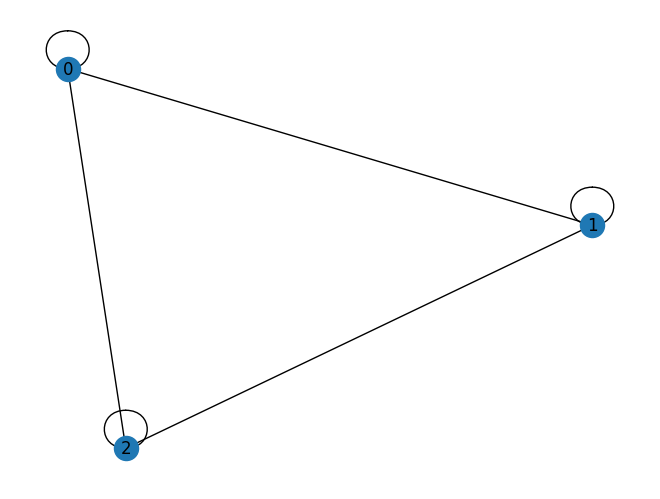

In [4]:


def torch_linear_system_to_graph(x, edge_index, edge_weights):
    graph = nx.Graph()
    for idx, el in np.ndenumerate(b):
        graph.add_node(idx[0], weight=el)
    for idx, el in np.ndenumerate(A):
        if el != 0.0:
            graph.add_edge(idx[0], idx[1], weight=el)
            graph.add_edge(idx[0], idx[1], weight=el)
    return graph

graph = linear_system_to_graph(A, b)
nx.draw(graph, with_labels=True)

In [5]:
# from pyqtorch.matrices import generate_ising_from_graph, sum_N
from pyqtorch.matrices import ZZ, NN, single_N, single_Z

def generate_hamiltonian_from_graph(graph,
                              precomputed_zz=None,
                              type_ising='Z',
                              device='cpu',
                              use_edge_weights=True,
                              use_self_loops=False,
                              use_node_weights=False,
                             ):
    
    """ Given a nx graph, generate the corresponding Ising Hamiltonian in PyQ format. """
    
    # get the number of nodes
    N = graph.number_of_nodes()
    
    # construct the hamiltonian
    H = torch.zeros(2**N, dtype=torch.cdouble).to(device)
    
    # edge weights 
    # go throught the edges and put the ZZ between correspoding nodes
    for edge in graph.edges.data():
        
        # check that the types are integers, otherwise code will run but graph will be incorrect
        assert type(edge[0]) == int
        assert type(edge[1]) == int
        
        # initialize edge weights
        edge_weight = torch.tensor(1, dtype=torch.cdouble)
        if use_edge_weights:
            if len(edge[2]) > 0:
                edge_weight = torch.tensor(edge[2]['weight'],  dtype=torch.cdouble)
        
        # if you already have ZZ(N, edge[0], edge[1], device) computed
        if precomputed_zz is not None:
            if (edge[0], edge[1]) in precomputed_zz[N]:
                key = (edge[0], edge[1])
            else:
                key = (edge[1], edge[0])
            H += edge_weight * precomputed_zz[N][key]
        else:
            # define 
            if type_ising == 'Z':
                if use_self_loops:
                    H += edge_weight * ZZ(N, edge[0], edge[1], device)
                elif edge[0] != edge[1]:
                    H += edge_weight * ZZ(N, edge[0], edge[1], device)
            elif type_ising == 'N':
                if use_self_loops:
                    H += edge_weight * NN(N, edge[0], edge[1], device)
                elif edge[0] != edge[1]:
                    H += edge_weight * NN(N, edge[0], edge[1], device)
            else:
                raise ValueError("'type_ising' must be in ['Z', 'N']")
    
    # node weights
    if use_node_weights:
        for node in graph.nodes.data():
            assert type(node[0]) == int
            if len(node[1]) > 0:
                node_weight = torch.tensor(node[1]['weight'],  dtype=torch.cdouble)
                if type_ising == 'N':
                    H += node_weight * single_N(N, node[0], device)
                elif type_ising == 'Z':
                    H += node_weight * single_Z(N, node[0], device)
                else:
                    raise ValueError("'type_ising' must be in ['Z', 'N']")
           
    return H

graph_hamiltonian_raw = generate_hamiltonian_from_graph(graph, type_ising='Z',
                                                       use_edge_weights=True,
                                                       use_self_loops=True,
                                                       use_node_weights=True)
print(graph_hamiltonian_raw.shape)
graph_hamiltonian = graph_hamiltonian_raw.reshape([2] * n_nodes + [1])
print(graph_hamiltonian.shape)
graph_cost = graph_hamiltonian #1.2*ising_matrix - sum_N(n_nodes)

torch.Size([2])
torch.Size([4])
torch.Size([8])
torch.Size([2, 2, 2, 1])


In [6]:
print(graph_hamiltonian_raw) # these must be the diagonal elements
print(graph_hamiltonian)

tensor([21.+0.j,  7.+0.j,  7.+0.j,  1.+0.j,  7.+0.j,  1.+0.j,  1.+0.j,  3.+0.j],
       dtype=torch.complex128)
tensor([[[[21.+0.j],
          [ 7.+0.j]],

         [[ 7.+0.j],
          [ 1.+0.j]]],


        [[[ 7.+0.j],
          [ 1.+0.j]],

         [[ 1.+0.j],
          [ 3.+0.j]]]], dtype=torch.complex128)


# Define a model to run the simulation

In [7]:
class MIS(QuantumCircuit):
    """ Construct the circuit of QAOA and compute the expectation value. """
    def __init__(self, n_qubits, n_layers):
        super().__init__(n_qubits)
        self.beta = nn.Parameter(torch.empty(n_layers,))
        self.gamma = nn.Parameter(torch.empty(n_layers,))
        self.reset_parameters()
        
    def reset_parameters(self):
        init.uniform_(self.beta, -2 * np.pi, 2 * np.pi)
        init.uniform_(self.gamma, -2 * np.pi, 2 * np.pi)
        
    def forward(self, return_cost=False):
        state = self.uniform_state()
        for b, g in zip(self.beta, self.gamma):
            state = state * torch.exp(-1j * g * graph_hamiltonian)
            for i in range(self.n_qubits):
                state = RX(b, state, [i], self.n_qubits)
        if return_cost:
            return torch.real(torch.sum(torch.abs(state)**2 * graph_cost))
        else:
            state = state.reshape((2**self.n_qubits,))
            return torch.abs(state)**2

        
class Model(QuantumCircuit):
    """ Construct the circuit, embed the data x and compute the expectation value. """
    def __init__(self, n_qubits, n_layers, return_cost):
        super().__init__(n_qubits)
        self.ansatz1 = AlternateLayerAnsatz(n_qubits, n_layers) # hardware-efficient
        self.embedding = SingleLayerEncoding(n_qubits)
        self.ansatz2 = AlternateLayerAnsatz(n_qubits, n_layers)

    def reset_parameters(self):
        init.uniform_(self.beta, -2 * np.pi, 2 * np.pi)
        init.uniform_(self.gamma, -2 * np.pi, 2 * np.pi)
    
    def forward(self, x):
        batch_size = len(x)
        state = self.init_state(batch_size)
        state = self.ansatz1(state)
        state = self.embedding(state, x)
        state = self.ansatz2(state)
        
        if return_cost:
            return torch.real(torch.sum(torch.abs(state)**2 * graph_cost))
        else:
            new_state = Z(state, [0], self.n_qubits)
            state = state.reshape((2**self.n_qubits, batch_size))
            new_state = new_state.reshape((2**self.n_qubits, batch_size))
            return torch.real(torch.sum(torch.conj(state) * new_state, axis=0))

In [8]:
class GraphHamiltonianEncoding(QuantumCircuit):
    def __init__(self, n_qubits, n_layers, graph_hamiltonian, parameters=None):
        super().__init__(n_qubits)
        self.gamma = nn.Parameter(torch.empty(n_layers,))
        if parameters == None:
            self.reset_parameters()
        else:
            self.gamma = parameters
    
    def reset_parameters(self):
        init.uniform_(self.gamma, -2 * np.pi, 2 * np.pi)
    
    def forward(self, state):
        print(self.gamma)
        for g in self.gamma:
            state = state * torch.exp(-1j * g * graph_hamiltonian)
        return state

In [9]:
%%timeit -n 10000 -r 10
# won't update the result just time it 
n_layers = 1
g = nn.Parameter(torch.tensor([0.3 for _ in range(n_layers)]))
exp = torch.exp(-1j * g * graph_hamiltonian)
# print(exp.shape)

14 µs ± 251 ns per loop (mean ± std. dev. of 10 runs, 10,000 loops each)


In [10]:
n_layers = 1
g = nn.Parameter(torch.tensor([0.5 for _ in range(n_layers)]))
exp = torch.exp(-1j * g * graph_hamiltonian)

In [12]:
print(exp)

tensor([[[[-0.4755+0.8797j],
          [-0.9365+0.3508j]],

         [[-0.9365+0.3508j],
          [ 0.8776-0.4794j]]],


        [[[-0.9365+0.3508j],
          [ 0.8776-0.4794j]],

         [[ 0.8776-0.4794j],
          [ 0.0707-0.9975j]]]], dtype=torch.complex128, grad_fn=<ExpBackward0>)


Trying to make it to avoid reexponentiating, it is possible partly but won't allow for continuous evolution.

In [13]:
class Exponentiation(torch.nn.Module):
    def __init__(
        self,
        graph_hamiltonian,
        parameters=None,
    ):
        super().__init__()
        self.graph_hamiltonian = graph_hamiltonian
        if parameters is None:
            self.g = nn.Parameter(torch.tensor([1.1 for _ in range(n_layers)]))
        else:
            self.g = parameters

    def forward(self):
        return torch.exp(-1j * self.g * self.graph_hamiltonian)

g = nn.Parameter(torch.tensor([10. for _ in range(n_layers)]))
# print(g)
exp = Exponentiation(graph_hamiltonian, parameters=g)
# print(eval_exp)

In [14]:
%%timeit -n 10000 -r 10
eval_exp = exp.forward()

10.6 µs ± 358 ns per loop (mean ± std. dev. of 10 runs, 10,000 loops each)


In [15]:
eval_exp = exp.forward()

In [16]:
print(eval_exp)

tensor([[[[-0.8839-0.4677j],
          [ 0.6333-0.7739j]],

         [[ 0.6333-0.7739j],
          [-0.8391+0.5440j]]],


        [[[ 0.6333-0.7739j],
          [-0.8391+0.5440j]],

         [[-0.8391+0.5440j],
          [ 0.1543+0.9880j]]]], dtype=torch.complex128, grad_fn=<ExpBackward0>)


In [17]:
def set_nn_parameters(list_parameters, flow):
    # change all parameters
    state_dict = flow.state_dict()
    count = 0
    for name, param in state_dict.items():
#         print(name, param)
        # Transform the parameter as required.
        transformed_param = torch.tensor(list_parameters[count])
        # Update the parameter.
        param.copy_(transformed_param)
        count += 1

In [18]:
%%timeit -n 10000 -r 10
set_nn_parameters([1.1], exp)

4.35 µs ± 110 ns per loop (mean ± std. dev. of 10 runs, 10,000 loops each)


In [19]:
set_nn_parameters([10.1], exp)

In [20]:
print(eval_exp)

tensor([[[[-0.8839-0.4677j],
          [ 0.6333-0.7739j]],

         [[ 0.6333-0.7739j],
          [-0.8391+0.5440j]]],


        [[[ 0.6333-0.7739j],
          [-0.8391+0.5440j]],

         [[-0.8391+0.5440j],
          [ 0.1543+0.9880j]]]], dtype=torch.complex128, grad_fn=<ExpBackward0>)


#### NOTE: You cannot modify the data just by resetting the parameters (you should trigger forward)
#### So what you try above does NOT work.

Encode the the graph into a Hamiltonian and embed in a quantum state.

In [21]:
n_layers = 1
parameters = nn.Parameter(torch.tensor([0.1 for _ in range(n_layers)]))
# print(parameters)
# parameters = nn.Parameter(torch.reshape(parameters, (n_layers,)))
print(parameters)
# parameters = None
model = GraphHamiltonianEncoding(n_qubits, n_layers=n_layers, graph_hamiltonian=graph_hamiltonian, parameters=parameters)
qc = QuantumCircuit(n_qubits)
state = qc.uniform_state()
print(state)
state = model(state)
print(state)

Parameter containing:
tensor([0.1000], requires_grad=True)
tensor([[[[0.3536+0.j],
          [0.3536+0.j]],

         [[0.3536+0.j],
          [0.3536+0.j]]],


        [[[0.3536+0.j],
          [0.3536+0.j]],

         [[0.3536+0.j],
          [0.3536+0.j]]]], dtype=torch.complex128)
Parameter containing:
tensor([0.1000], requires_grad=True)
tensor([[[[-0.1785-0.3052j],
          [ 0.2704-0.2278j]],

         [[ 0.2704-0.2278j],
          [ 0.3518-0.0353j]]],


        [[[ 0.2704-0.2278j],
          [ 0.3518-0.0353j]],

         [[ 0.3518-0.0353j],
          [ 0.3378-0.1045j]]]], dtype=torch.complex128, grad_fn=<MulBackward0>)


In [22]:
class Model(QuantumCircuit):
    """ Construct the circuit, embed the data x and compute the expectation value. """
    def __init__(self, n_qubits, n_layers, return_cost):
        super().__init__(n_qubits)
        self.ansatz1 = AlternateLayerAnsatz(n_qubits, n_layers) # hardware-efficient
        self.embedding = SingleLayerEncoding(n_qubits)
        self.ansatz2 = AlternateLayerAnsatz(n_qubits, n_layers)

    def reset_parameters(self):
        init.uniform_(self.beta, -2 * np.pi, 2 * np.pi)
        init.uniform_(self.gamma, -2 * np.pi, 2 * np.pi)
    
    def forward(self, x, edge_index, edge_attr):
        batch_size = len(x)
        state = self.init_state(batch_size)
        state = self.ansatz1(state)
        state = self.embedding(state, x)
        state = self.ansatz2(state)
        if return_cost:
            return torch.real(torch.sum(torch.abs(state)**2 * graph_cost))
        else:
            new_state = Z(state, [0], self.n_qubits)
            state = state.reshape((2**self.n_qubits, batch_size))
            new_state = new_state.reshape((2**self.n_qubits, batch_size))
            return torch.real(torch.sum(torch.conj(state) * new_state, axis=0))

In [23]:
model = MIS(n_nodes, 20)
# model = Model(n_nodes, 20, return_cost=True)

optimizer = torch.optim.Adam(model.parameters(), lr=.02)
epochs = 500

for epoch in range(epochs):
    optimizer.zero_grad()
    loss = model(True)
    loss.backward()
    optimizer.step()
    print(state.shape)
    print(state)
    print(f"Epoch {epoch+1} | Loss {loss}")

torch.Size([2, 2, 2, 1])
tensor([[[[-0.1785-0.3052j],
          [ 0.2704-0.2278j]],

         [[ 0.2704-0.2278j],
          [ 0.3518-0.0353j]]],


        [[[ 0.2704-0.2278j],
          [ 0.3518-0.0353j]],

         [[ 0.3518-0.0353j],
          [ 0.3378-0.1045j]]]], dtype=torch.complex128, grad_fn=<MulBackward0>)
Epoch 1 | Loss 3.5156372576025503
torch.Size([2, 2, 2, 1])
tensor([[[[-0.1785-0.3052j],
          [ 0.2704-0.2278j]],

         [[ 0.2704-0.2278j],
          [ 0.3518-0.0353j]]],


        [[[ 0.2704-0.2278j],
          [ 0.3518-0.0353j]],

         [[ 0.3518-0.0353j],
          [ 0.3378-0.1045j]]]], dtype=torch.complex128, grad_fn=<MulBackward0>)
Epoch 2 | Loss 11.8831857499901
torch.Size([2, 2, 2, 1])
tensor([[[[-0.1785-0.3052j],
          [ 0.2704-0.2278j]],

         [[ 0.2704-0.2278j],
          [ 0.3518-0.0353j]]],


        [[[ 0.2704-0.2278j],
          [ 0.3518-0.0353j]],

         [[ 0.3518-0.0353j],
          [ 0.3378-0.1045j]]]], dtype=torch.complex128, grad_fn=<M

In [24]:
prob = model()
print(prob)
mis = torch.argmax(prob)
print(mis.item())
# print(format(mis, '010b'))
"{0:b}".format(mis.item())

tensor([2.1166e-07, 1.3728e-10, 1.3728e-10, 3.3333e-01, 1.3728e-10, 3.3333e-01,
        3.3333e-01, 3.4452e-08], dtype=torch.float64, grad_fn=<PowBackward0>)
3


'11'